## Global To Dos:
* read paper
* [steps document](https://docs.google.com/document/d/1du2fcmVzTqnW0FWGmUxvpR2t6QEfwxDIrHSZs9k3HZM/edit?usp=sharing)

Section 1: Load and Preprocess Data

In [31]:
import utils_preprocessing as up
import utils as ut
import importlib
importlib.reload(ut)
importlib.reload(up)
from itertools import groupby
import yaml
import os
import textdistance
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

## Pre-processing 

Read in YAML and make PATH

In [32]:
#with open("config.yml", 'r') as ymlfile:
#    cfg = yaml.load(ymlfile)

#PATH = os.path.join(cfg['data']['Directory'] + ":" + os.sep, cfg['data']['Folder1'], cfg['data']['Folder2'], cfg['data']['Folder3']) # Alix Path

PATH = 'SOTU/'
#PATH = '/Users/aleistermontfort/Desktop/speeches' # Aleister Path
filetype = '*txt'

Read in Data

In [33]:
speeches, numpar = up.reading_data(PATH,'*.txt')

Create Noun Phrases

In [34]:
new_speeches = up.chunks(speeches, "spacy")

Clean Words & Lemmatize Noun Phrases: Spacy - Skip if used Regex Above

In [35]:
clean_speeches = up.clean_words(new_speeches)

Lemmatize Noun Phrases: Regex - Skip if Used Regex Above

In [36]:
words_changed = up.word_changes(clean_speeches, 0.5, 100)

In [37]:
phrases_lemmed = up.lemmed_phrases(words_changed, new_speeches)

Counting Occurrence of Terms

In [38]:
counted_words = up.count_words(phrases_lemmed)

Limit List to Top 1000

In [39]:
top_words = up.top_x(counted_words, 1000)
top_words

[Mr. Speaker,
 Mr. President,
 distinguished Members,
 the Congress,
 honored guests,
 fellow citizens,
 Today,
 my first State,
 the Union address,
 you,
 a constitutional duty,
 our Republic,
 itself,
 President Washington,
 this tradition,
 the Nation,
 the destiny,
 self-government,
 the "preservation,
 the sacred fire,
 liberty,
 the experiment,
 the hands,
 the American people,
 our friends,
 the press,
 who,
 a high premium,
 accuracy,
 me,
 I,
 George Washington,
 it,
 a matter,
 historic record,
 this podium,
 Winston Churchill,
 the free world,
 the onslaught,
 aggression,
 Franklin Delano Roosevelt,
 a day,
 a nation,
 arms,
 Douglas MacArthur,
 an unforgettable farewell,
 a country,
 he,
 Dwight Eisenhower,
 us,
 peace,
 the price,
 strength,
 John F. Kennedy,
 the burden,
 glory,
 freedom,
 I,
 this Chamber,
 a newcomer,
 Washington,
 past policies,
 I,
 I,
 a new spirit,
 partnership,
 this Congress,
 this administration,
 Washington,
 our State and local governments,
 th

limit paragraph phrases only to those in top 1000

In [40]:
limited_paragraphs = up.limit(phrases_lemmed, top_words)

## Periodization

In [41]:
tfidfs = up.corpus_tfidf(limited_paragraphs, counted_words, top_words)

In [42]:
periods, dissimilarity = up.periodization(tfidfs)

In [43]:
import operator
sorted_x = sorted(periods.items(), key=operator.itemgetter(1))
years = dissimilarity.index

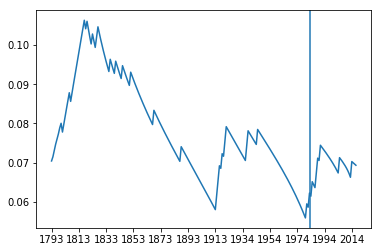

In [44]:
import matplotlib.pylab as plt
import matplotlib.ticker as ticker

lists = sorted(periods.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples

ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
plt.axvline(pd.to_numeric(sorted_x[0][0])-pd.to_numeric(years[0]), 0,1)
plt.plot(x, y)
plt.show()

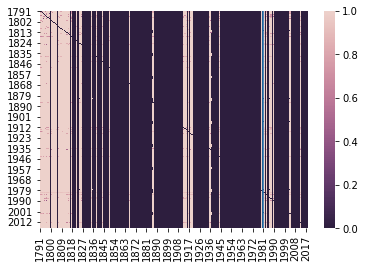

In [45]:
import seaborn as sns
cmap = sns.cubehelix_palette(as_cmap=True, reverse=True)
ax = sns.heatmap(dissimilarity, cmap=cmap)
plt.axvline((pd.to_numeric(sorted_x[0][0])-pd.to_numeric(years[0])), 0,1)
plt.show()

### Before

Before Years

In [46]:

before_1914 = years[:pd.to_numeric(sorted_x[0][0])-pd.to_numeric(years[0])]
before_dict = {k: v for k, v in limited_paragraphs.items() if k[1] in before_1914}

Before TFIDF

In [47]:
before_tfidfs = up.corpus_tfidf(before_dict, counted_words, top_words)

In [48]:
before_periods, before_dissimilarity = up.periodization(before_tfidfs)

### After

After Years

In [49]:
after_1914 = years[pd.to_numeric(sorted_x[0][0])-pd.to_numeric(years[0]):]
after_dict = {k: v for k, v in limited_paragraphs.items() if k[1] in after_1914}

After TFIDF

In [50]:
after_tfidfs = up.corpus_tfidf(after_dict, counted_words, top_words)

In [51]:
after_periods, after_dissimilarity = up.periodization(after_tfidfs)

In [52]:
new_periods = {**before_periods, **after_periods}

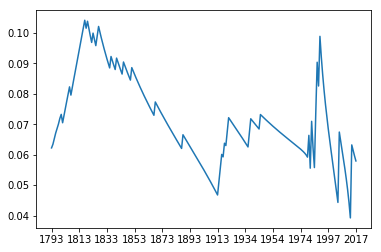

In [53]:
import matplotlib.pylab as plt
import matplotlib.ticker as ticker

lists = sorted(new_periods.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples

ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))

plt.plot(x, y)
plt.show()

## Co-Occurrence Matrix and Dissimilarity Topic Modeling

Build the co-occurrence matrix

In [54]:
pre_occur = ut.convert_dict_to_list(limited_paragraphs)

In [55]:
co_occur = ut.co_oc_matrix(pre_occur, True, True)

KeyError: unemployment

Do a cosine similarity

In [ ]:
co_matrix = ut.pairwise_similarity(co_occur, 'cosine')

Do a paper dissimilarity

In [ ]:
co_matrix_paper = ut.pairwise_similarity(co_occur, 'paper')

# This is breaking so returning to a prior saved version of spacy

In [11]:
co_occur.columns[co_occur.isna().any()].tolist()

[]

In [10]:
co_occur = pd.read_csv('spacy_co_occurence.csv', index_col = 0)

### Global Corpus

For the next section, if you're working on regex then include 'regex' in the parameters of the network graphing function. If you're working off spacy, include 'spacy' in the parameters of the network graphing function

In [15]:
#nounphrase = 'regex'
nounphrase = 'spacy'

Create network graph using community detection algorithms and paper's approach

In [29]:
global_cda_paper = ut.network_graph(co_matrix_paper, 'community', nounphrase, 'global', 'paper')

NetworkXError: Input is not a valid edge list

Create network graph using community detection algorithms and cosine similarity

['mr speaker', 'the congress', 'the price', 'the people', 'million', 'the state', 'the union', 'a series', 'construction', 'a reduction', 'the rate', 'increase', 'tax', 'the increase', 'the beginning', 'the expense', 'the cost', 'waste', 'fraud', 'this year', 'the budget', 'office', 'a change', 'law', 'revenue', 'the number', 'employee', 'the department', 'the last year', 'the system', 'the time', 'a bill', 'the next year', 'operation', 'aid', 'the federal government', 'the national government', 'the return', 'transportation', 'the extent', 'hand', 'legislation', 'dollar', 'service', 'the land', 'the enactment', 'the house', 'detail', 'the past year', 'the year', 'the difference', 'a period', 'the condition', 'the present', 'the evil', 'my message', 'the experience', 'my opinion', 'combination', 'corporation', 'experience', 'money', 'the public', 'the place', 'the farmer', 'connection', 'the power', 'the constitution', 'this power', 'practice', 'the several state', 'regulation', 'this 

Networks/global_spacy_cosine_community.png


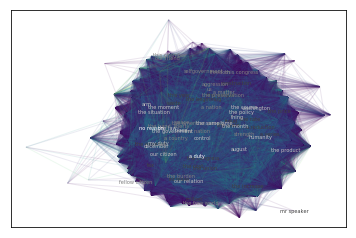

In [16]:
global_cda_cosine = ut.network_graph(co_matrix, 'community', nounphrase, 'global', 'cosine')

Create network graph using kmeans unsupervised clustering and paper's approach 

In [37]:
global_kmeans_paper = ut.network_graph(co_matrix_paper, 'kmeans', nounphrase, 'global', 'paper')

NetworkXError: Input is not a valid edge list

Create network graph using kmeans unsupervised clustering and cosine similarity 

['the price', 'the union', 'the situation', 'a series', 'the beginning', 'the expense', 'the cost', 'fraud', 'the product', 'office', 'a change', 'the number', 'the department', 'the last year', 'the system', 'a bill', 'operation', 'aid', 'the federal government', 'dollar', 'service', 'the enactment', 'the difference', 'my message', 'the regulation', 'the experience', 'my opinion', 'money', 'the public', 'the constitution', 'practice', 'the several state', 'regulation', 'the passage', 'a law', 'its provision', 'its operation', 'the enforcement', 'manufacture', 'this system', 'the soil', 'the executive department', 'a commission', 'competition', 'the issue', 'the amount', 'your attention', 'line', 'the employment', 'the creation', 'the united state', 'return', 'the north', 'the secretary', 'the last session', 'administration', 'several year', 'use', 'the prosperity', 'the army', 'their duty', 'the bill', 'attention', 'the building', 'the service', 'the officer', 'the head', 'the busines

Networks/global_spacy_cosine_kmeans.png


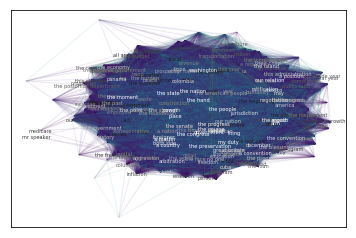

In [23]:
global_kmeans_cosine= ut.network_graph(co_matrix, 'kmeans', nounphrase, 'global', 'cosine')

### Before 1914 Corpus

First turn the before dictionary into a co-occurrence matrix and create cosine and dissimilarity versions of it

In [24]:
before_occur = ut.convert_dict_to_list(before_dict)
co_before = ut.co_oc_matrix(before_occur, True, False)
before_cosine = ut.pairwise_similarity(co_before, 'cosine')
before_paper = ut.pairwise_similarity(co_before, 'paper')

NameError: name 'before_dict' is not defined

Create network graph using community detection algorithm and paper dissimilarity

In [40]:
before_cda_paper = ut.network_graph(before_paper, 'community', nounphrase, 'before', 'paper')

NetworkXError: Input is not a valid edge list

Create network graph using community detection algorithm and cosine dissimilarity

In [ ]:
before_cda_cosine = ut.network_graph(before_cosine, 'community', nounphrase, 'before', 'cosine')

Create network graph using kmeans and paper dissimilarity

In [ ]:
before_kmeans_paper = ut.network_graph(before_paper, 'kmeans', nounphrase, 'before', 'paper')

Create network graph using kmeans and cosine similarity

In [ ]:
before_kmeans_cosine = ut.network_graph(before_cosine, 'kmeans', nounphrase, 'before', 'cosine')

### After 1914 Corpus

First turn the after dictionary into a co-occurrence matrix and create cosine and dissimilarity versions of it

In [ ]:
after_occur = ut.convert_dict_to_list(after_dict)
co_after = ut.co_oc_matrix(after_occur, True, False)
after_cosine = ut.pairwise_similarity(co_after, 'cosine')
after_paper = ut.pairwise_similarity(co_after, 'paper')

Create network graph using community detection algorithm and paper dissimilarity

In [ ]:
after_cda_paper = ut.network_graph(after_paper, 'community', nounphrase, 'after', 'paper')

Create network graph using community detection algorithm and cosine dissimilarity

In [ ]:
after_cda_cosine = ut.network_graph(after_cosine, 'community', nounphrase, 'after', 'cosine')

Create network graph using kmeans and paper dissimilarity

In [ ]:
after_kmeans_paper = ut.network_graph(after_paper, 'kmeans', nounphrase, 'after', 'paper')

Create network graph using kmeans and cosine similarity

In [ ]:
after_kmeans_cosine = ut.network_graph(after_cosine, 'kmeans', nounphrase, 'after', 'cosine')